R²: 0.3111906723689657
RMSE: 21.431689285184582
Coefficients: [ 2.23445755e-01  1.94861568e+00 -6.65957779e-02  3.78780779e-01
  1.40452541e-03  2.25557048e-01]


C:\Users\Jeremy\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Jeremy\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Jeremy\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Jeremy\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_

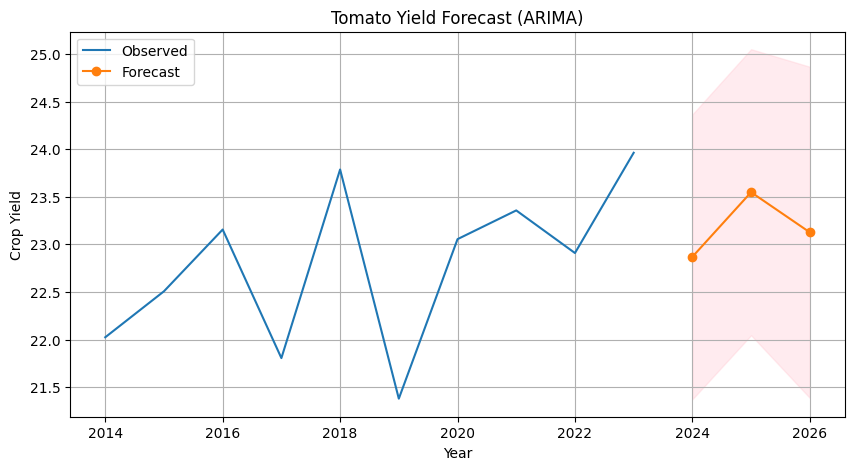

                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -10.967
Date:                Tue, 16 Sep 2025   AIC                             27.934
Time:                        21:13:31   BIC                             28.525
Sample:                             0   HQIC                            26.657
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6209      0.309     -2.011      0.044      -1.226      -0.016
ma.L1         -0.4710      0.521     -0.904      0.366      -1.492       0.550
sigma2         0.5829      0.502      1.161      0.2

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ds = pd.read_csv("crop_yield_dataset.csv")
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month



# -------------------
# Standard Regression
# -------------------

# Select features (from your EDA results)
X = ds[["Soil_Quality", "Humidity", "N", "P", "K", "Soil_pH"]]
y = ds["Crop_Yield"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficients:", model.coef_)

# -------------------
# ARIMA
# -------------------

# Filter dataset for tomato yields by year
tomato = ds[ds["Crop_Type"] == "Tomato"].groupby("Year")["Crop_Yield"].mean()


# Fit ARIMA (p,d,q = simple example)
model = ARIMA(tomato, order=(1,1,1))  # AR=1, I=1, MA=1
results = model.fit()
# AR (p) = auto-regression - depends on past values (like yield in 2022).
# I (d) = differencing - helps remove trends (e.g., steady growth each year).
# MA (q) = moving average - depends on past forecast errors.
# Look back 1 lag in yields,
# Difference once to remove trend,
# Use 1 lag of errors

# Forecast with confidence intervals
forecast = results.get_forecast(steps=3)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()


plt.figure(figsize=(10,5))
plt.plot(tomato.index, tomato.values, label="Observed")
plt.plot(range(tomato.index.max()+1, tomato.index.max()+4), mean_forecast, label="Forecast", marker="o")

# Add confidence intervals
plt.fill_between(range(tomato.index.max()+1, tomato.index.max()+4),
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='pink', alpha=0.3)

# Plot
plt.title("Tomato Yield Forecast (ARIMA)")
plt.xlabel("Year")
plt.ylabel("Crop Yield")
plt.grid(True)
plt.legend()
plt.show()

print(results.summary())
